## Lead author effect

In [26]:
import pandas as pd
from tqdm.notebook import tqdm

from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
from math import log

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

from statsmodels.stats.multitest import multipletests

from scipy.stats import variation, bootstrap, kruskal, pearsonr, ttest_rel, wilcoxon, mannwhitneyu, iqr


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

def get_rmsd_summary(df_paths, structure_pair_to_same_author=None):

    rmsd_summary_df = []
    between_medians, within_np_medians, within_p_medians, medians_per_psite = calculate_medians(df_paths, structure_pair_to_same_author)

    columns = ["protein","residue","phosphosite","rmsd_between_groups","rmsd_within_phospho","rmsd_within_nonphospho"]
    for psite, v in medians_per_psite.items():
        protein, residue = psite.split("_")
        between_groups, within_phospho, within_nonphospho = v
        row = [protein, residue, psite, between_groups, within_phospho, within_nonphospho]
        rmsd_summary_df.append(row)

    rmsd_summary_df = pd.DataFrame(rmsd_summary_df, columns=columns)
    return rmsd_summary_df

def calculate_medians(df_paths, structure_pair_to_same_author):

    # Also return a dict to make things easier
    # protein: (median between, median phospho, median dephospho)
    
    between_medians = []
    within_np_medians = []
    within_p_medians = []
    
    medians_per_psite = {}
    
    for rmsd_df in df_paths:
        psite = rmsd_df.parts[-2]
        df = pd.read_csv(rmsd_df,dtype={"PDB_ID_A":str,"PDB_ID_B":str,
                                        "Chain_A":str, "Chain_B":str})
        
        df["structure_a"] = df["PDB_ID_A"] + "_" + df["Chain_A"]
        df["structure_b"] = df["PDB_ID_B"] + "_" + df["Chain_B"]

        if structure_pair_to_same_author:
            drop_idxs = []
            for idx, row in df.iterrows():
                structure_a = row["structure_a"]
                structure_b = row["structure_b"]
                same_author = structure_pair_to_same_author[(structure_a, structure_b)]
                if same_author == 1:
                    drop_idxs.append(idx)
            #print(psite)
            df = df.drop(index=drop_idxs)
        
        btwn = df[df["Group"] == "between_groups"]
            
        btwn_rmsd = btwn["RMSD"].values
        between_medians.append(np.nanmedian(btwn_rmsd))

        within_np = df[df["Group"] == "within_nonphospho"]
        within_np_rmsd = within_np["RMSD"].values
        within_np_medians.append(np.nanmedian(within_np_rmsd))

        within_p = df[df["Group"] == "within_phospho"]
        within_p_rmsd = within_p["RMSD"].values
        within_p_medians.append(np.nanmedian(within_p_rmsd))
        
        medians_per_psite[psite] = (np.nanmedian(btwn_rmsd),np.nanmedian(within_p_rmsd),np.nanmedian(within_np_rmsd))
    
    return between_medians, within_np_medians, within_p_medians, medians_per_psite




In [27]:
#rmsd_nosame_df["rmsd_between_groups"].dropna()

In [28]:
rmsd_nosame_df = pd.read_csv("../../results/rmsd_excluding_same_author/rmsd_summary_nosameauthor.csv",index_col=0)
rmsd_nosame_df = rmsd_nosame_df[["phosphosite","rmsd_between_groups","rmsd_within_phospho","rmsd_within_nonphospho"]]

In [29]:
rmsd_nosame_df

,phosphosite,rmsd_between_groups,rmsd_within_phospho,rmsd_within_nonphospho
0,P68400_2,0.797763,NaN,0.916891
1,Q99XG5_123,0.831468,NaN,0.897036
2,A0A2K3E0K3_178,3.725421,NaN,NaN
3,P25321_11,0.930640,0.933924,NaN
4,P47811_182,3.609952,1.666888,1.558086
...,...,...,...,...
342,P05132_11,0.527232,0.528823,0.532972
343,P28327_8,1.377362,NaN,1.554709
344,P61925_22,0.388321,0.308969,0.425117
345,O19069_299,1.265969,0.499409,1.942741


In [30]:
rmsd_summary_df_nosame_nodups = rmsd_nosame_df.drop_duplicates(subset=list(rmsd_nosame_df.columns)[3:])


In [31]:
rmsd_summary_df_nosame_nodups

,phosphosite,rmsd_between_groups,rmsd_within_phospho,rmsd_within_nonphospho
0,P68400_2,0.797763,NaN,0.916891
1,Q99XG5_123,0.831468,NaN,0.897036
2,A0A2K3E0K3_178,3.725421,NaN,NaN
4,P47811_182,3.609952,1.666888,1.558086
5,P07830_54,0.797514,NaN,0.716840
...,...,...,...,...
342,P05132_11,0.527232,0.528823,0.532972
343,P28327_8,1.377362,NaN,1.554709
344,P61925_22,0.388321,0.308969,0.425117
345,O19069_299,1.265969,0.499409,1.942741


In [32]:
out_path = Path("backbone_comparison_nosamelead")
out_path.mkdir(exist_ok=True)

In [33]:
color_palette=[sns.color_palette("Set1")[2],sns.color_palette("Set1")[4],sns.color_palette("Set1")[1]]

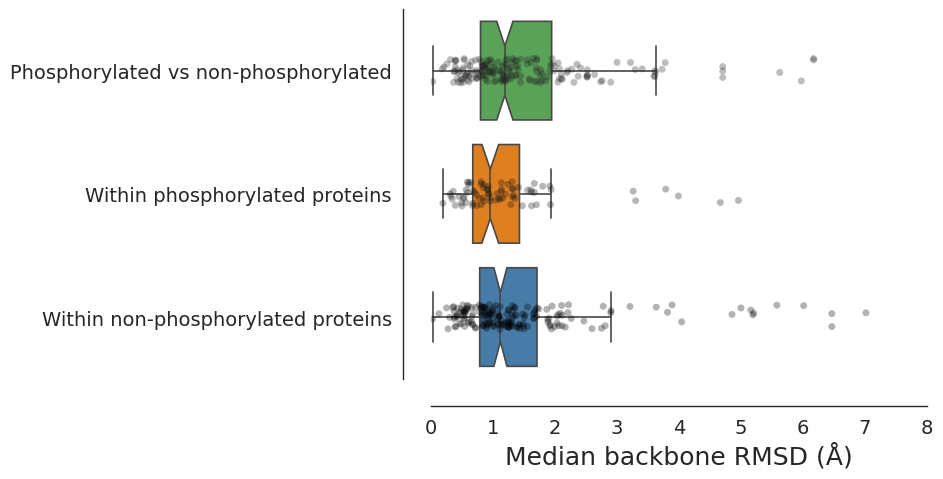

In [34]:
# Boxplot with all comparisons
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})
ax = sns.boxplot(data=rmsd_summary_df_nosame_nodups, orient="h", notch=True, showfliers = False,palette=color_palette)
ax = sns.stripplot(data=rmsd_summary_df_nosame_nodups, orient="h",palette='dark:black',alpha=0.3,jitter=True)

ax.set_yticklabels(["Phosphorylated vs non-phosphorylated","Within phosphorylated proteins","Within non-phosphorylated proteins"])
ax.set_xlabel("Median backbone RMSD (Å)",fontsize=18)

plt.xlim(0,8)
sns.despine(offset=20)
plt.savefig(out_path / "boxplot_groups.pdf",dpi=150,bbox_inches='tight')

In [35]:
# Drop rows where we have only one structure for phospho / non-phospho
rmsd_nosame_df_nona = rmsd_summary_df_nosame_nodups.dropna()


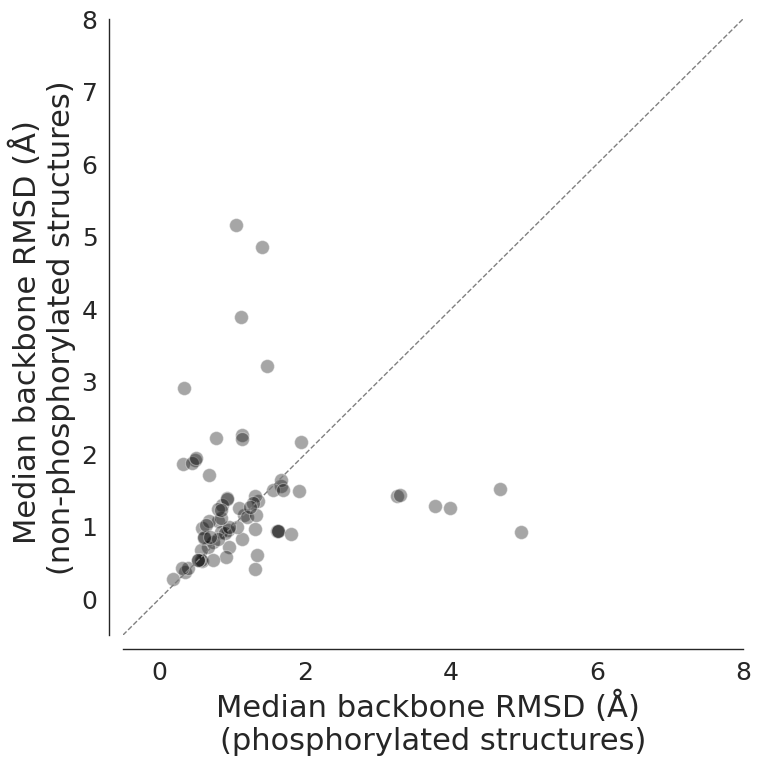

In [37]:
fig = plt.figure(figsize=(8,8))
sns.set_context('paper',rc={"xtick.labelsize":18,"ytick.labelsize":18})

axs = sns.scatterplot(data=rmsd_nosame_df_nona, x="rmsd_within_phospho",y="rmsd_within_nonphospho",
                alpha=0.35,c="black",s=100)
add_identity(axs, color='gray', ls='--', lw=1)
plt.ylabel("Median backbone RMSD (Å) \n(non-phosphorylated structures)",fontsize=22)
plt.xlabel("Median backbone RMSD (Å) \n(phosphorylated structures)",fontsize=22)
plt.xlim(-.5,8)
plt.ylim(-.5,8)

sns.despine(offset=10)
plt.savefig(out_path / "scatter_rmsd_phospho_vs_nonphospho.pdf",dpi=150, bbox_inches='tight')


### What is the median RMSD?

In [22]:
median_rmsd_change = rmsd_summary_df_nosame_nodups["rmsd_between_groups"].median()
std_rmsd_change = rmsd_summary_df_nosame_nodups["rmsd_between_groups"].std()
print(f"Median RMSD change {median_rmsd_change:3f}, stdev {std_rmsd_change:3f}")

median_rmsd_wp = rmsd_summary_df_nosame_nodups["rmsd_within_phospho"].median()
std_rmsd_wp = rmsd_summary_df_nosame_nodups["rmsd_within_phospho"].std()
print(f"Median RMSD within phosphorylated {median_rmsd_wp:3f}, stdev {std_rmsd_wp:3f}")

median_rmsd_wnp = rmsd_summary_df_nosame_nodups["rmsd_within_nonphospho"].median()
std_rmsd_wnp = rmsd_summary_df_nosame_nodups["rmsd_within_nonphospho"].std()
print(f"Median RMSD change within non-phosphorylated {median_rmsd_wnp:3f}, stdev {std_rmsd_wnp:3f}")

Median RMSD change 1.190293, stdev 2.293518
Median RMSD within phosphorylated 0.955372, stdev 1.244743
Median RMSD change within non-phosphorylated 1.118830, stdev 1.831620


In [24]:
rmsd_nosame_df_abovecutoff = rmsd_summary_df_nosame_nodups.loc[rmsd_summary_df_nosame_nodups["rmsd_between_groups"]>=2]
frac_above_2 = len(rmsd_nosame_df_abovecutoff)/len(rmsd_summary_df_nosame_nodups)
print(f"{100*frac_above_2:.3f} are above 2 angstroms")


23.158 are above 2 angstroms


## Statistical differences between groups

In [13]:
rmsd_summary_df_all_nona = rmsd_nosame_df[["rmsd_between_groups", "rmsd_within_phospho", "rmsd_within_nonphospho"]].dropna()
rmsd_summary_df_nona = rmsd_nosame_df[["rmsd_within_phospho","rmsd_within_nonphospho"]].dropna()

In [14]:
mwu_stat_np_between, mwu_pval_np_between = mannwhitneyu(rmsd_summary_df_all_nona["rmsd_between_groups"],rmsd_summary_df_all_nona["rmsd_within_nonphospho"],alternative='greater')
mwu_stat_p_between, mwu_pval_p_between = mannwhitneyu(rmsd_summary_df_all_nona["rmsd_between_groups"],rmsd_summary_df_all_nona["rmsd_within_phospho"],alternative='greater')

In [15]:
adj_pvals = multipletests([mwu_pval_np_between, mwu_pval_p_between], alpha=0.05, method='fdr_bh')
adj_pvals

(array([False, False]),
 array([0.40202367, 0.09644051]),
 0.025320565519103666,
 0.025)

In [16]:
wilcox_stat, wilcox_pval = wilcoxon(rmsd_summary_df_nona["rmsd_within_phospho"],rmsd_summary_df_nona["rmsd_within_nonphospho"])
print(wilcox_stat, wilcox_pval)


1164.0 0.16813224697876594
